In [196]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

In [197]:
EV_Stations = pd.DataFrame(pd.read_csv('predicted_stations.csv'))
EV_Grid = pd.DataFrame(pd.read_csv('predicted_grid.csv'))

In [198]:
EV_Stations = EV_Stations.drop(columns='Unnamed: 0')
EV_Stations = EV_Stations.loc[(EV_Stations['Year'] >= 2010) & (EV_Stations['Year'] <= 2022)]
EV_Stations 

,Year,Total_Installed
2,2010,7.0
3,2011,57.0
4,2012,38.0
5,2013,16.0
6,2014,38.0
7,2015,65.0
8,2016,81.0
9,2017,97.0
10,2018,106.0
11,2019,174.0


In [208]:
EV_Vehicles = pd.DataFrame(pd.read_csv('predicted_vehicles.csv'))
EV_Vehicles = EV_Vehicles.drop(columns='Unnamed: 0')
EV_Vehicles = EV_Vehicles.loc[(EV_Vehicles['Year'] >= 2010) & (EV_Vehicles['Year'] <= 2022)]
EV_Vehicles

,Year,Total_Sold
0,2010,3.0
1,2011,13.0
2,2012,14.0
3,2013,19.0
4,2014,17.0
5,2015,32.0
6,2016,38.0
7,2017,64.0
8,2018,100.0
9,2019,147.0


In [200]:
EV_Grid = EV_Grid.loc[(EV_Grid['Year'] >= 2010) & (EV_Grid['Year'] <= 2022)]
EV_Grid

,Predicted_MWH,Year
20,1.034727e+08,2010
21,1.152626e+08,2011
22,1.168355e+08,2012
23,1.141729e+08,2013
24,1.163344e+08,2014
25,1.092875e+08,2015
26,1.140866e+08,2016
27,1.159121e+08,2017
28,1.167567e+08,2018
29,1.064636e+08,2019


In [201]:
import math

# create a copy of the ev_grid array
ev_grid_scaled = EV_Grid.copy()

# select the predicted column
predicted_column = ev_grid_scaled['Predicted_MWH']

# scale the ev_grid value for all rows except the last row
predicted_column[:-1] = predicted_column[:-1] / math.exp(8)

# multiply the last row by e^7
#predicted_column[-1] = predicted_column[-1] * math.exp(7)
last_row = ev_grid_scaled.tail(1)
last_row = last_row / math.exp(8)
# change the last row of the predicted column
ev_grid_scaled.iloc[-1, ev_grid_scaled.columns.get_loc('Predicted_MWH')] = last_row
# update the predicted column in the ev_grid_scaled array
ev_grid_scaled['Predicted_MWH'] = predicted_column


ev_grid_scaled['Predicted_MWH'] = ev_grid_scaled['Predicted_MWH'].astype(int)
EV_Grid=ev_grid_scaled

EV_Grid

,Predicted_MWH,Year
20,34711,2010
21,38666,2011
22,39193,2012
23,38300,2013
24,39025,2014
25,36661,2015
26,38271,2016
27,38884,2017
28,39167,2018
29,35714,2019


In [202]:
print(EV_Vehicles.shape)
print(EV_Stations.shape)
print(EV_Grid.shape)

(13, 2)
(13, 2)
(13, 2)


In [203]:
# split the data into X (features) and y (target)
df = pd.merge(EV_Stations, EV_Vehicles, on='Year')
df

,Year,Total_Installed,Total_Sold
0,2010,7.0,3.0
1,2011,57.0,13.0
2,2012,38.0,14.0
3,2013,16.0,19.0
4,2014,38.0,17.0
5,2015,65.0,32.0
6,2016,81.0,38.0
7,2017,97.0,64.0
8,2018,106.0,100.0
9,2019,174.0,147.0


In [207]:
df = pd.merge(df, EV_Grid, on = 'Year')
df['Total_Sold']

0       3.0
1      13.0
2      14.0
3      19.0
4      17.0
5      32.0
6      38.0
7      64.0
8     100.0
9     147.0
10    174.0
11    300.0
12    526.0
Name: Total_Sold, dtype: float64

In [10]:
X = np.array(df[['Total_Installed', 'Total_Sold', 'Year']])
y = np.array(df['Predicted_MWH'])
print(X.shape)
print(y.shape)

(13, 3)
(13,)


In [63]:
import torch
from torch import nn

num_inputs = 3
num_outputs = 1

hidden_size = [32, 64]

model = nn.Sequential(
nn.Linear(num_inputs, hidden_size[0]),
nn.ReLU(),
nn.Linear(hidden_size[0], hidden_size[1]),
nn.ReLU(),
nn.Linear(hidden_size[1], num_outputs),
)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# create an instance of the MinMaxScaler
scaler_x = MinMaxScaler()
#scaler_y = MinMaxScaler()

y=y.reshape(-1,1)

# fit the scaler to the data
scaler_x.fit(X)
#scaler_y.fit(y)

# transform the data
X = scaler_x.transform(X)
#y = scaler_y.transform(y)

# normalize and scale the data
X_mean = X.mean()
X_std = X.std()
y_mean = y.mean()
y_std = y.std()

X = (X - X_mean) / X_std
y = (y - y_mean) / y_std

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# convert the data to tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [64]:
# define the loss function and optimizer
criterion = nn.MSELoss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters())

print(model)
# train the model
for epoch in range(100):
    # forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print training and testing accuracy
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred_test = model(X_test)
            test_loss = criterion(y_pred_test, y_test)
            print(f'Epoch {epoch+1}/100: Testing loss = {test_loss.item():.4f}')

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 1/100: Testing loss = 0.9744
Epoch 11/100: Testing loss = 1.1169
Epoch 21/100: Testing loss = 1.3002
Epoch 31/100: Testing loss = 1.5387
Epoch 41/100: Testing loss = 1.8401
Epoch 51/100: Testing loss = 2.1334
Epoch 61/100: Testing loss = 2.3153
Epoch 71/100: Testing loss = 2.3752
Epoch 81/100: Testing loss = 2.3745
Epoch 91/100: Testing loss = 2.3584


In [65]:
# create a new data point
X_new = pd.DataFrame({'Year': [2022], 'Total_Installed': [264.0], 'Total_Sold': [526.0]})

# convert the data to a tensor
X_new = torch.from_numpy(X_new.values).float()

# normalize and scale the data
#X_new = (X_new - X_mean) / X_std

# make predictions using the model
y_pred = model(X_new)

# de-normalize the prediction
y_pred = abs(y_pred.item())
print(f'Predicted grid power for 2022 with 264 EV stations and EV Vehicles with 526: {abs(y_pred):.4f}')

Predicted grid power for 2022 with 264 EV stations and EV Vehicles with 526: 941.3757


In [67]:
y_pred*math.exp(4)

51397.37014392396

In [166]:
import torch.nn as nn

# Define the model
class PowerGridPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)       
        return x

# Instantiate the model
model = PowerGridPredictor(input_size=3,hidden_size = [32, 64], output_size=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# Normalize and scale the data
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

y = y.reshape(-1, 1)

scaler_x.fit(X)
scaler_y.fit(y)

X = scaler_x.transform(X)
y = scaler_y.transform(y)

X_mean = X.mean()
X_std = X.std()
y_mean = y.mean()
y_std = y.std()

X = (X - X_mean) / X_std
y = (y - y_mean) / y_std

# Split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Convert the data to tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

# Train the model
for epoch in range(100):
        # forward pass
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print training and testing accuracy
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred_test = model(X_test)
            test_loss = criterion(y_pred_test, y_test)
            print(f'Epoch {epoch+1}/3000: Testing loss = {test_loss.item():.4f}')

Epoch 1/3000: Testing loss = 2.9901
Epoch 11/3000: Testing loss = 2.7553
Epoch 21/3000: Testing loss = 2.7346
Epoch 31/3000: Testing loss = 2.7663
Epoch 41/3000: Testing loss = 2.8172
Epoch 51/3000: Testing loss = 2.8757
Epoch 61/3000: Testing loss = 2.9352
Epoch 71/3000: Testing loss = 2.9908
Epoch 81/3000: Testing loss = 3.0449
Epoch 91/3000: Testing loss = 3.0994


In [167]:
# create a new data point
X_new = pd.DataFrame({'Year': [2022], 'Total_Installed': [264.0], 'Total_Sold': [526.0]})

# convert the data to a tensor
X_new = torch.from_numpy(X_new.values).float()

# normalize and scale the data
#X_new = (X_new - X_mean) / X_std

# make predictions using the model
y_pred = model(X_new)

# de-normalize the prediction
y_pred = abs(y_pred.item())
print(f'Predicted grid power for 2022 with 264 EV stations and EV Vehicles with 526: {abs(y_pred):.4f}')

Predicted grid power for 2022 with 264 EV stations and EV Vehicles with 526: 423.4166


In [170]:
y_pred*math.exp(4.5)

38114.747268251325

In [215]:
import pandas as pd
import torch
import math

# Define the year and number of stations lists
year = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033]
stations = [7.0, 57.0, 38.0, 16.0, 38.0, 65.0, 81.0, 97.0, 106.0, 174.0, 206.0, 683.0, 264.0, 238.11287478,256.39153439, 274.670194,   292.94885362, 311.22751323, 329.50617284, 347.78483245, 366.06349206, 384.34215168, 402.62081129,420.8994709]

vehicles = [3.0, 13.0, 14.0, 19.0, 17.0, 32.0, 38.0, 64.0, 100.0, 147.0, 174.0, 300.0, 526.0, 359.0, 392.0, 425.0, 458.0, 491.0, 524.0, 557.0, 590.0, 623.0, 656.0, 689.0]
# Create empty lists to store the predictions
predictions = []

# Round up or down depending on the decimal place
stations = [math.ceil(n) if n % 1 >= 0.5 else math.floor(n) for n in stations]

# Iterate over the year and number of stations lists
for i in range(len(year)):
    # Create a new data point
    X_new = pd.DataFrame({'Year': [year[i]], 'Total_Installed': [stations[i]],'Total_Sold': [vehicles[i]]})

    # Convert the data to a tensor
    X_new = torch.from_numpy(X_new.values).float()

    # Normalize and scale the data
    #X_new = (X_new - X_mean) / X_std

    # Make predictions using the model
    y_pred = model(X_new)

    # Multiply the prediction by e^4
    result = y_pred * math.exp(4.5)
    
    # Add the prediction to the list
    predictions.append(abs(result.item()))

# Print the predictions
print(predictions)

[31566.955078125, 33155.3515625, 32570.166015625, 31887.642578125, 32599.392578125, 33458.09375, 33975.1640625, 34479.31640625, 34755.91015625, 36888.93359375, 37897.80859375, 53932.015625, 38114.74609375, 38446.68359375, 38789.27734375, 39162.05859375, 39504.65625, 39847.25, 40220.03515625, 40562.62890625, 40905.22265625, 40959.6875, 40814.44140625, 40646.6796875]


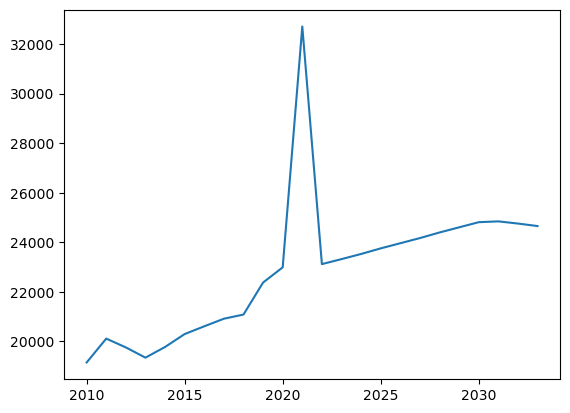

In [214]:
plt.plot(year,predictions)

In [217]:
import numpy as np

# Convert the list of values to a NumPy array
predictions = np.array(predictions)

# Shift the values by exp(8)
predictions = predictions * np.exp(8)

print(predictions)  # prints [2980.95799, 2981.95799, 2982.95799, 2983.95799, 2984.95799]


[9.40997669e+07 9.88347101e+07 9.70902965e+07 9.50557228e+07
 9.71774197e+07 9.97371718e+07 1.01278537e+08 1.02781394e+08
 1.03605908e+08 1.09964361e+08 1.12971775e+08 1.60769073e+08
 1.13618457e+08 1.14607949e+08 1.15629206e+08 1.16740451e+08
 1.17761721e+08 1.18782978e+08 1.19894235e+08 1.20915493e+08
 1.21936750e+08 1.22099108e+08 1.21666135e+08 1.21166044e+08]


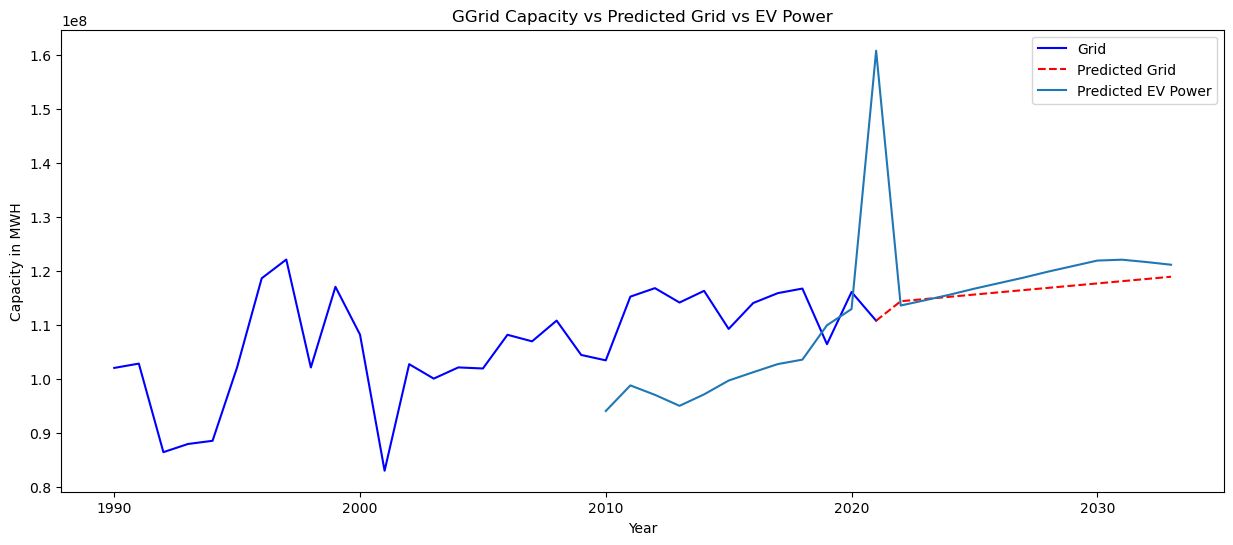

In [222]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.DataFrame(pd.read_csv('annual_generation_WA.csv'))

x= np.arange(32) + 1990

y = df.Total.values

n = np.size(x)

fig=plt.figure(figsize = (15,6))
plt.title('GGrid Capacity vs Predicted Grid vs EV Power')
plt.plot(x,y, '-b', label='Grid')
plt.xlabel('Year')
plt.ylabel('Capacity in MWH')

EV_Grid = pd.DataFrame(pd.read_csv('predicted_grid.csv'))
EV_Grid = EV_Grid.loc[(EV_Grid['Year'] >= 2021) & (EV_Grid['Year'] <= 2033)]
EV_Grid

x= EV_Grid.Year.values
y = EV_Grid.Predicted_MWH.values
plt.plot(x,y, '--r', label='Predicted Grid')
plt.plot(year,predictions, label='Predicted EV Power')
plt.legend()
fig.savefig('Grid Capacity vs Predicted Grid vs EV Power.jpg', bbox_inches='tight', dpi=150)

In [91]:
import tensorflow as tf
import pandas as pd

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(13, input_dim=3, activation='relu'))
model.add(tf.keras.layers.Dense(26, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='Adagrad')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Use the model to make predictions
predictions = model.predict(X_test)

Epoch 1/100
1/1 [==============================] - 1s 653ms/step - loss: 0.5376 - val_loss: 0.0216
Epoch 2/100
1/1 [==============================] - 0s 59ms/step - loss: 0.5289 - val_loss: 0.0198
Epoch 3/100
1/1 [==============================] - 0s 68ms/step - loss: 0.5216 - val_loss: 0.0183
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 0.5152 - val_loss: 0.0170
Epoch 5/100
1/1 [==============================] - 0s 75ms/step - loss: 0.5096 - val_loss: 0.0159
Epoch 6/100
1/1 [==============================] - 0s 93ms/step - loss: 0.5045 - val_loss: 0.0149
Epoch 7/100
1/1 [==============================] - 0s 79ms/step - loss: 0.4998 - val_loss: 0.0139
Epoch 8/100
1/1 [==============================] - 0s 77ms/step - loss: 0.4953 - val_loss: 0.0131
Epoch 9/100
1/1 [==============================] - 0s 79ms/step - loss: 0.4912 - val_loss: 0.0123
Epoch 10/100
1/1 [==============================] - 0s 81ms/step - loss: 0.4873 - val_loss: 0.0116
Epoch 11/100
1/1 [

1/1 [==============================] - 0s 88ms/step - loss: 0.3740 - val_loss: 0.0065
Epoch 84/100
1/1 [==============================] - 0s 80ms/step - loss: 0.3733 - val_loss: 0.0066
Epoch 85/100
1/1 [==============================] - 0s 73ms/step - loss: 0.3726 - val_loss: 0.0068
Epoch 86/100
1/1 [==============================] - 0s 75ms/step - loss: 0.3719 - val_loss: 0.0069
Epoch 87/100
1/1 [==============================] - 0s 76ms/step - loss: 0.3713 - val_loss: 0.0071
Epoch 88/100
1/1 [==============================] - 0s 89ms/step - loss: 0.3706 - val_loss: 0.0072
Epoch 89/100
1/1 [==============================] - 0s 83ms/step - loss: 0.3699 - val_loss: 0.0073
Epoch 90/100
1/1 [==============================] - 0s 95ms/step - loss: 0.3693 - val_loss: 0.0075
Epoch 91/100
1/1 [==============================] - 0s 100ms/step - loss: 0.3686 - val_loss: 0.0076
Epoch 92/100
1/1 [==============================] - 0s 100ms/step - loss: 0.3680 - val_loss: 0.0078
Epoch 93/100
1/1 [===

In [164]:
# Test the model
#loss, mse = model.evaluate(X_test, y_test)
#print("Test loss:", loss)
#print("Test MSE:", mse)

# Define the input features for the new data
new_data = [[2023, 2640, 5260]]  # year, number of stations, number of vehicles
print(new_data)
# Use the model to make predictions on the new data
predictions = model.predict(new_data)

# Print the predictions
print(predictions)

[[2023, 2640, 5260]]
1/1 [==============================] - 0s 38ms/step
[[310.1568]]


In [165]:
abs(predictions*math.exp(5))

array([[46031.35]], dtype=float32)

In [160]:
import pandas as pd
import torch
import math

# Define the year and number of stations lists
year = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033]
stations = [238.11287478, 256.39153439, 274.670194, 292.94885362, 311.22751323,329.50617284,347.78483245,366.06349206,384.34215168,402.62081129,420.8994709]
vehicles = [359, 392, 425, 458, 491, 524, 557, 590, 623, 656, 689]


import math

# Round up or down depending on the decimal place
stations = [math.ceil(n) if n % 1 >= 0.5 else math.floor(n) for n in stations]

import itertools
data = [[y, s, v] for y, s, v in itertools.zip_longest(year, stations, vehicles, fillvalue=None)]
data[0:1]

[[2023, 238, 359]]

In [159]:
#predictions = []
#data_array = np.array(data)

# Define the input features for the new data
#for i in range(len(data_array[:,0])):
#    new_data = [data[i:i+1]]  # year, number of stations, number of vehicles

    # Use the model to make predictions on the new data
#    predictions = model.predict(abs(new_data)*math.exp(5))

# Print the predictions
#print(predictions)

TypeError: bad operand type for abs(): 'list'